In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import differential_evolution as de

import sys
sys.path.append("../models/")
import gr4j

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
meteo = pd.read_pickle("../data/meteo_nelka.pkl")

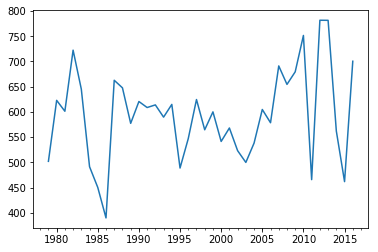

In [3]:
meteo["Prec"].resample("A").sum().plot()

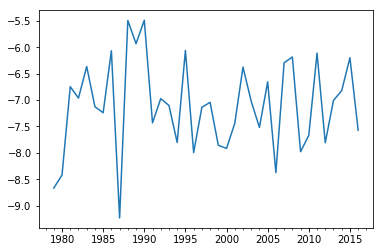

In [4]:
meteo["Temp"].resample("A").mean().plot()

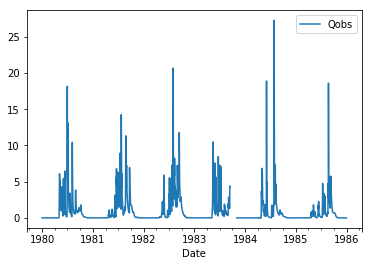

In [5]:
runoff= pd.read_pickle("../data/runoff_nelka.pkl")

area = 30.8
coef = (86400*1000)/(area*1000000)

runoff = pd.DataFrame(runoff * coef)
runoff.columns = ["Qobs"]

runoff["1980":].plot()

In [6]:
periods = {"first"  : ["1980-01-01", "1982-12-31"], 
           "second" : ["1983-01-01", "1985-12-31"], 
           "full"   : ["1980-01-01", "1985-12-31"]}

In [7]:
def NS(obs, sim):
    
    numerator = np.nansum( (obs - sim)**2 )
    
    denominator = np.nansum( (obs - np.nanmean(obs))**2 )
    
    return 1 - numerator / denominator

In [8]:
opt_pars = {'first' : np.array([2.83722215e+02, 7.05682184e-01, 1.78846738e+01, 2.13065737e+00, 1.69027623e-01, 3.67987870e+00]), 
            'second': np.array([6.66034958e+02, 1.81201518e-01, 8.27679790e+00, 2.04745081e+00, 7.43708427e-01, 5.96813778e+00]), 
            'full'  : np.array([390.87276986,   0.46892242,  13.37185012,   2.06929369, 0.51522738,   4.70385877])}

In [9]:
# Calculate a simulated runoff and place it in the one pandas DataFrame
qsim = pd.concat([pd.DataFrame({"Qsim_{}".format(period) : gr4j.simulation(meteo, opt_pars[period])}, index = meteo.index) for period in opt_pars.keys()], axis=1)

In [10]:
# Create a helper pandas DataFrame for holding all the data together
qdf = pd.concat([qsim, runoff], axis=1)

In [11]:
# Calculate a calibration/validation matrix

## Create a holder
validation_array = np.zeros((3, 3))

## Calibration periods in rows
for i, period_name in enumerate(periods.keys()):
    
    ## Validation periods in columns
    for j, period_instance in enumerate(periods.values()):
        
        Qo = runoff[period_instance[0]: period_instance[1]]
        
        Qs = qdf["Qsim_"+period_name][period_instance[0]: period_instance[1]]
        
        Q_df = pd.concat([Qs, Qo], axis=1).dropna()
        
        validation_array[i, j] = NS(Q_df["Qobs"].values, Q_df["Qsim_"+period_name].values)
        

# Convert to a pandas DataFrame for a nice look
validation_table = pd.DataFrame(validation_array, columns=periods.keys(), index=periods.keys())

# Plot the results
validation_table

,first,second,full
first,0.563315,0.366138,0.479098
second,0.475892,0.458502,0.471822
full,0.544513,0.440275,0.501545


In [12]:
# Read in HYDROGRAPH model results
qsim_hydrograph = pd.read_csv("../data/runoff_nelka_hydrograph.csv", header=0, index_col=0, parse_dates=True, names=["Hydrograph"])

qsim_hydrograph = qsim_hydrograph.shift(-1)

# Convert the baseline solution back to m3/s and concatenate with HYdrograph model results
qdf = pd.concat([qdf / coef, qsim_hydrograph], axis=1)

qdf = qdf.dropna()

In [13]:
# Year-wise NS BASELINE
baseline_NS = [NS(qdf["Qobs"][str(year)], qdf["Qsim_full"][str(year)]) for year in range(1980, 1986)]

hydrograph_NS = [NS(qdf["Qobs"][str(year)], qdf["Hydrograph"][str(year)]) for year in range(1980, 1986)]

In [14]:
print("baseline, full period NS:", NS(qdf["Qobs"]["1980":"1985"], qdf["Qsim_full"]["1980":"1985"]))
print("hydrograph, full period NS:", NS(qdf["Qobs"]["1980":"1985"], qdf["Hydrograph"]["1980":"1985"]))

baseline, full period NS: 0.5015113871163779
hydrograph, full period NS: 0.7391606380988647


Text(0,0.5,'NS')

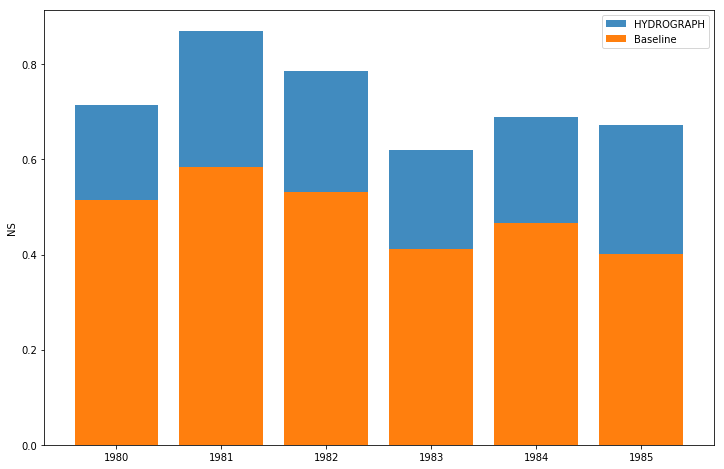

In [15]:
plt.figure(figsize=(12, 8))
plt.bar([i for i in range(1980, 1986)], hydrograph_NS, alpha=0.85, label="HYDROGRAPH")
plt.bar([i for i in range(1980, 1986)], baseline_NS, label="Baseline")
plt.legend()
plt.ylabel("NS")

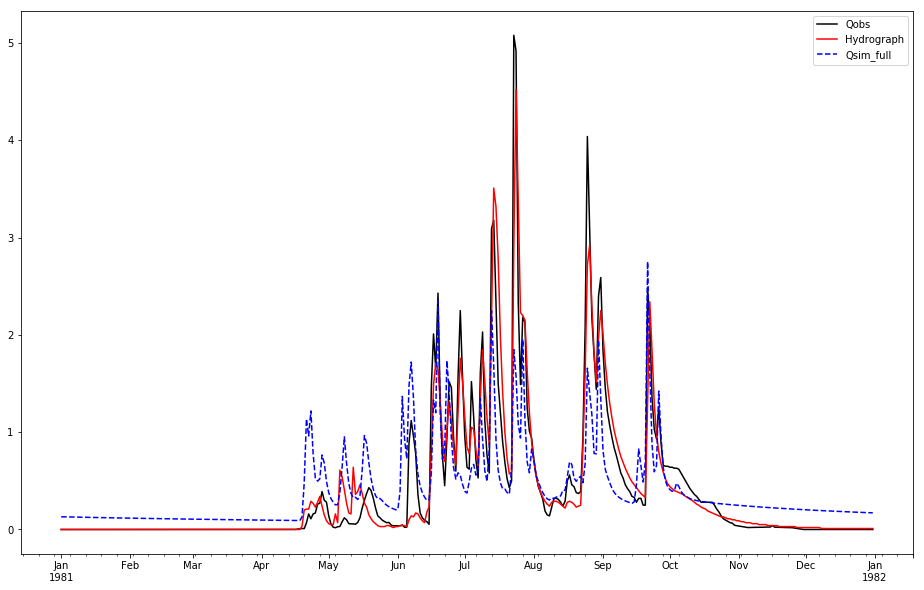

In [16]:
qdf[["Qobs", "Hydrograph", "Qsim_full"]]["1981"].plot(style=["k-", "r-", "b--"], figsize=(16,10))

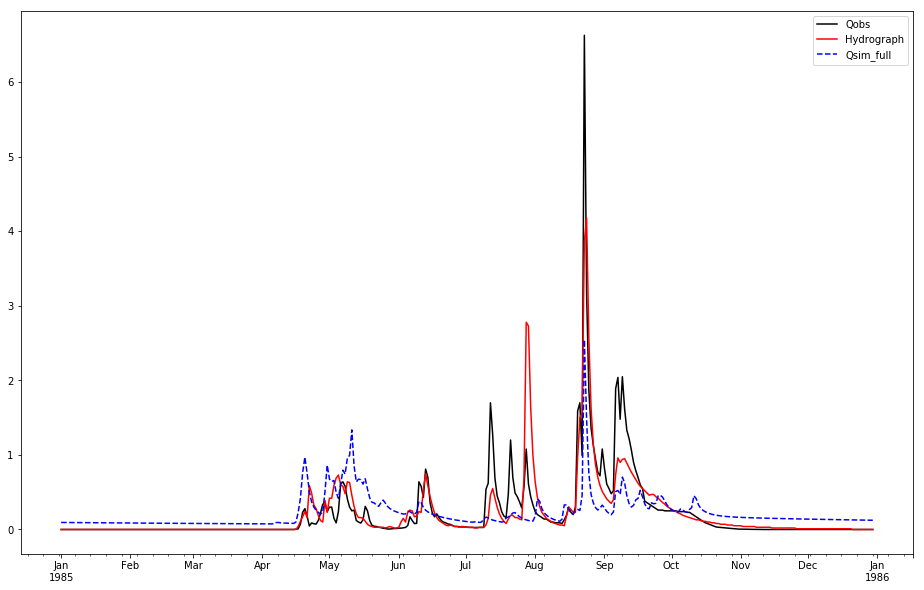

In [17]:
qdf[["Qobs", "Hydrograph", "Qsim_full"]]["1985"].plot(style=["k-", "r-", "b--"], figsize=(16,10))

$$ NSE = 1-\frac{\sum_{i=1}^{N}(obs_{i}-sim_{i})^2}{\sum_{i=1}^{N}(obs_{i}-\bar{obs})^2} $$

_______________

$$ NSE_{gain} = 1-\frac{\sum_{i=1}^{N}(obs_{i}-sim_{i})^2}{\sum_{i=1}^{N}(obs_{i}-baseline_{i})^2} $$

In [18]:
def NS_gain(obs, sim, baseline):
    
    numerator = np.nansum( (obs - sim)**2 )
    
    denominator = np.nansum( (obs - baseline)**2 )
    
    return 1 - numerator / denominator

In [19]:
gain_NS = [NS_gain(qdf["Qobs"][str(year)], qdf["Hydrograph"][str(year)], qdf["Qsim_full"][str(year)]) for year in range(1980, 1986)]

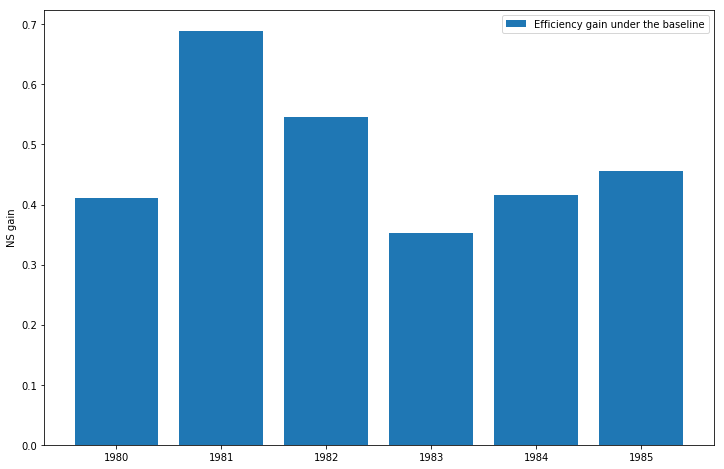

In [20]:
plt.figure(figsize=(12, 8))
plt.bar([i for i in range(1980, 1986)], gain_NS, label="Efficiency gain under the baseline")
plt.ylabel("NS gain")
plt.legend()

In [21]:
print("Full period efficiency gain: ", NS_gain(qdf["Qobs"]["1980":"1985"], qdf["Hydrograph"]["1980":"1985"], qdf["Qsim_full"]["1980":"1985"]))

Full period efficiency gain:  0.4767395780773207
